In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')
 !cp /content/drive/MyDrive/dataset_images.zip /content/
 !unzip dataset_images.zip

## **Data Preprocessing**

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("dataset_columns.csv")
df = df[['Image Index', 'Finding Labels']].dropna()
df['Image Index'] = df['Image Index'].str.strip().str.lower()
df['Finding Labels'] = df['Finding Labels'].str.strip()
unique_conditions = set()

for entry in df['Finding Labels']:
    labels = entry.split('|')
    unique_conditions.update(labels)

unique_conditions = sorted(list(unique_conditions))
condition_to_index = {cond: idx for idx, cond in enumerate(unique_conditions)}
index_to_condition = {idx: cond for cond, idx in condition_to_index.items()}
num_conditions = len(unique_conditions)

def encode_multilabel(label_str):
    label_vector = [0] * num_conditions
    for cond in label_str.split('|'):
        if cond in condition_to_index:
            label_vector[condition_to_index[cond]] = 1
    return label_vector

df['encoded'] = df['Finding Labels'].apply(encode_multilabel)
df[['Image Index', 'Finding Labels', 'encoded']].head()
image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
image_dir = 'merged_images2'
output_dir = 'split_dataset'

os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

all_images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
print(f"Found {len(all_images)} images in directory")

matched_images = []
matched_labels = []
missing_count = 0

for img in all_images:
    key = img.strip().lower()
    if key in image_labels:
        matched_images.append(img)  
        matched_labels.append(image_labels[key])
    else:
        missing_count += 1
print(f"Matched {len(matched_images)} images with labels")
print(f"{missing_count} images had no matching label")

if len(matched_images) == 0:
    raise ValueError("No images matched with labels in image_labels dictionary!")

X_train, X_temp, y_train, y_temp = train_test_split(matched_images, matched_labels, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def process_dataset(images, labels, subset):
    subset_dir = os.path.join(output_dir, subset)
    label_file = os.path.join(output_dir, f'{subset}_labels.txt')

    for img in images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(subset_dir, img)
        shutil.copyfile(src, dst)

    with open(label_file, 'w') as f:
        for img, label in zip(images, labels):
            f.write(f"{img} {label}\n")

process_dataset(X_train, y_train, 'train')
process_dataset(X_val, y_val, 'val')
process_dataset(X_test, y_test, 'test')

print("\nDataset splitting complete!")
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")
print(f"Total matched: {len(matched_images)} images")
print(f"Total unmatched: {missing_count} images")


Found 60990 images in directory
Matched 60990 images with labels
0 images had no matching label

Dataset splitting complete!
Train: 42693 images
Validation: 9148 images
Test: 9149 images
Total matched: 60990 images
Total unmatched: 0 images


Each class distribution

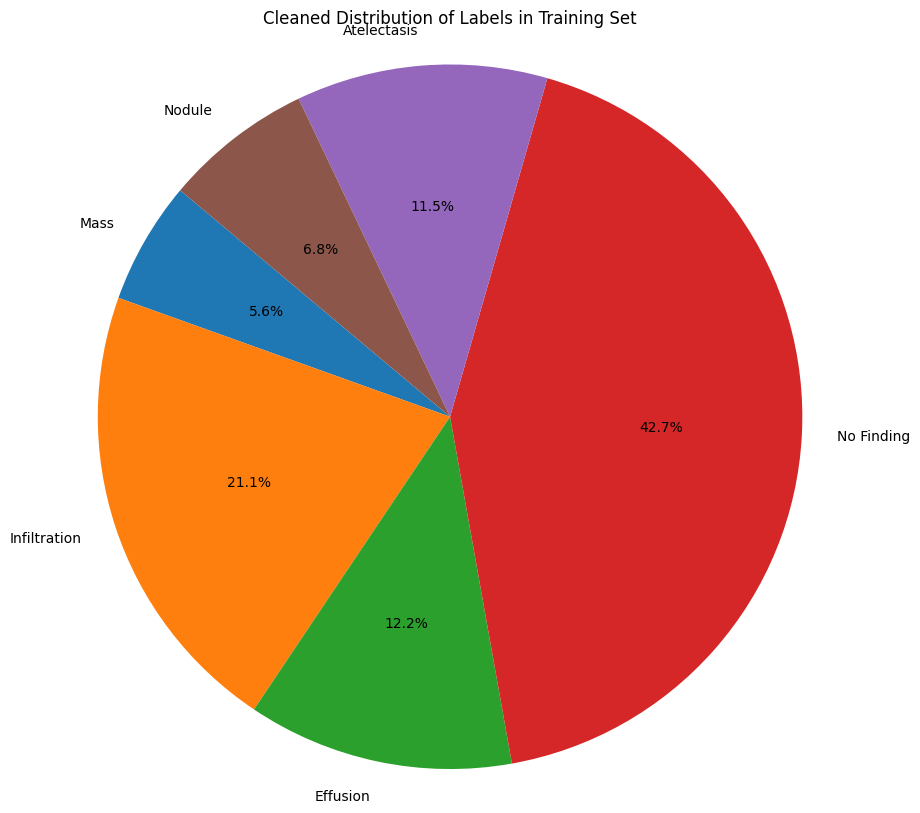

In [ ]:

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("dataset_columns.csv")
df = df[['Image Index', 'Finding Labels']].dropna()
df['Image Index'] = df['Image Index'].str.strip().str.lower()
df['Finding Labels'] = df['Finding Labels'].str.strip()

unique_conditions = sorted(set(label for labels in df['Finding Labels'] for label in labels.split('|')))
condition_to_index = {cond: idx for idx, cond in enumerate(unique_conditions)}

from sklearn.model_selection import train_test_split
matched_images = df['Image Index'].tolist()
matched_labels = df['Finding Labels'].tolist()
X_train, X_temp, y_train, y_temp = train_test_split(matched_images, matched_labels, test_size=0.3, random_state=42)

train_label_list = [label.strip() for entry in y_train for label in entry.split('|')]
label_counts = Counter(train_label_list)

labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Cleaned Distribution of Labels in Training Set')
plt.axis('equal')
plt.show()


### **Neural Network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet18Scratch(nn.Module):
    def __init__(self, num_classes=41):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        def make_layer(in_channels, out_channels, num_blocks, stride):
            layers = []
            for i in range(num_blocks):
                s = stride if i == 0 else 1
                shortcut = nn.Sequential()
                if s != 1 or in_channels != out_channels:
                    shortcut = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=s, bias=False),
                        nn.BatchNorm2d(out_channels)
                    )
                layers.append(nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=s, padding=1, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(out_channels),
                    shortcut
                ))
                in_channels = out_channels
            return nn.ModuleList(layers)

        self.layer1 = make_layer(64, 64, 2, stride=1)
        self.layer2 = make_layer(64, 128, 2, stride=2)
        self.layer3 = make_layer(128, 256, 2, stride=2)
        self.layer4 = make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        for block in self.layer1:
            identity = x
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            x = F.relu(out + block[5](identity))

        for block in self.layer2:
            identity = x
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            x = F.relu(out + block[5](identity))

        for block in self.layer3:
            identity = x
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            x = F.relu(out + block[5](identity))

        for block in self.layer4:
            identity = x
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            x = F.relu(out + block[5](identity))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return self.fc(x)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_imgs, total_imgs = 0.0, 0, 0
    all_preds, all_targets = [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct_imgs += (preds == labels).all(dim=1).sum().item()
        total_imgs   += labels.size(0)

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    return (
        running_loss / len(dataloader),                   
        100.0 * correct_imgs / total_imgs,                
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score   (y_true, y_pred, average='macro', zero_division=0),
        f1_score       (y_true, y_pred, average='macro', zero_division=0)
    )


In [ ]:
 COLLECT_ROC = True
_val_logits, _val_targets = [], []

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_imgs, total_imgs = 0.0, 0, 0
    all_preds, all_targets, all_logits = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss   = criterion(logits, labels)
            running_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct_imgs += (preds == labels).all(dim=1).sum().item()
            total_imgs   += labels.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())
            if COLLECT_ROC:
                all_logits.append(logits.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    if COLLECT_ROC:
        _val_logits.append(torch.cat(all_logits))
        _val_targets.append(torch.from_numpy(y_true))

    return (
        running_loss / len(dataloader),
        100.0 * correct_imgs / total_imgs,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score   (y_true, y_pred, average='macro', zero_division=0),
        f1_score       (y_true, y_pred, average='macro', zero_division=0)
    )

In [ ]:
import os
os.environ['cuda_LAUNCH_BLOCKING'] = '1'


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os

all_conditions = set()
for labels in image_labels.values():
    all_conditions.update(labels.split('|'))

all_conditions = sorted(list(all_conditions))
condition_to_index = {cond: idx for idx, cond in enumerate(all_conditions)}
index_to_condition = {idx: cond for cond, idx in condition_to_index.items()}
num_classes = len(all_conditions)

print(" Detected number of classes (multi-label):", num_classes)
print("Sample class indices:", condition_to_index)

def encode_multilabel(label_str):
    label_vector = [0] * num_classes

    for cond in label_str.split('|'):
        if cond in condition_to_index:
            label_vector[condition_to_index[cond]] = 1

    return label_vector

y_train = [encode_multilabel(image_labels[img]) for img in X_train]
y_val = [encode_multilabel(image_labels[img]) for img in X_val]
y_test = [encode_multilabel(image_labels[img]) for img in X_test]

class LabeledImageDataset(Dataset):
    def __init__(self, image_filenames, labels, image_dir, transform=None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

device = "cuda"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = LabeledImageDataset(X_train, y_train, 'split_dataset/train', transform)
val_dataset = LabeledImageDataset(X_val, y_val, 'split_dataset/val', transform)

img, label = train_dataset[0]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

model = ResNet18Scratch(num_classes=num_classes)
model = model.to(device)

with torch.no_grad():
    dummy = torch.randn(1, 1, 224, 224).to(device)
    out = model(dummy)
    print(" Output shape from dummy pass:", out.shape)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

 Detected number of classes (multi-label): 6
Sample class indices: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2, 'Mass': 3, 'No Finding': 4, 'Nodule': 5}
 Output shape from dummy pass: torch.Size([1, 6])


In [ ]:
import time

train_losses, val_losses  = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s  = [], []

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1 = train_model(model, train_loader, optimizer, criterion, device)
    vl_loss, vl_acc, vl_prec, vl_rec, vl_f1 = evaluate_model(model, val_loader, criterion, device)
    train_losses.append(tr_loss); val_losses.append(vl_loss)
    train_accuracies.append(tr_acc); val_accuracies.append(vl_acc)
    train_f1s.append(tr_f1); val_f1s.append(vl_f1)
    elapsed = time.time() - start_time
    eta = elapsed * (num_epochs - epoch)
    current_lr = optimizer.param_groups[0]["lr"]

    print(f"\nEpoch {epoch:2d}/{num_epochs}  •  "
          f"Time {elapsed:.2f}s  •  ETA {eta/60:.1f} min  •  LR {current_lr:.2e}")
    print(f"  Train — Loss {tr_loss:.4f} | Acc {tr_acc:.2f}% | "
          f"Prec {tr_prec:.2f} | Rec {tr_rec:.2f} | F1 {tr_f1:.2f}")
    print(f"  Val   — Loss {vl_loss:.4f} | Acc {vl_acc:.2f}% | "
          f"Prec {vl_prec:.2f} | Rec {vl_rec:.2f} | F1 {vl_f1:.2f}")

 Detected number of classes (multi-label): 6
Sample class indices: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2, 'Mass': 3, 'No Finding': 4, 'Nodule': 5}
 Output shape from dummy pass: torch.Size([1, 6])

Epoch  1/10  •  Time 79.87s  •  ETA 12.0 min  •  LR 1.00e-04
  Train — Loss 0.5126 | Acc 2.95% | Prec 0.29 | Rec 0.06 | F1 0.09
  Val   — Loss 0.5102 | Acc 3.82% | Prec 0.44 | Rec 0.06 | F1 0.10

Epoch  2/10  •  Time 77.57s  •  ETA 10.3 min  •  LR 1.00e-04
  Train — Loss 0.4885 | Acc 6.23% | Prec 0.45 | Rec 0.12 | F1 0.17
  Val   — Loss 0.5011 | Acc 6.76% | Prec 0.59 | Rec 0.15 | F1 0.19

Epoch  3/10  •  Time 77.41s  •  ETA 9.0 min  •  LR 1.00e-04
  Train — Loss 0.4736 | Acc 9.18% | Prec 0.52 | Rec 0.16 | F1 0.23
  Val   — Loss 0.5063 | Acc 16.35% | Prec 0.50 | Rec 0.17 | F1 0.20

Epoch  4/10  •  Time 77.31s  •  ETA 7.7 min  •  LR 1.00e-04
  Train — Loss 0.4599 | Acc 12.19% | Prec 0.60 | Rec 0.21 | F1 0.28
  Val   — Loss 0.5167 | Acc 10.76% | Prec 0.52 | Rec 0.17 | F1 0.20

Epo

In [ ]:
torch.save(model.state_dict(), "resnet_model.pth")

In [ ]:
import pandas as pd
from pathlib import Path
from datetime import datetime

out_dir = Path("runs") / datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir.mkdir(parents=True, exist_ok=True)

epochs = range(1, len(train_losses) + 1)
df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accuracies,
    "val_acc": val_accuracies,
    "train_f1":  train_f1s,
    "val_f1": val_f1s,
})

combined_csv = out_dir / "training_metrics.csv"
df.to_csv(combined_csv, index=False)
print(f"✓ Saved combined metrics → {combined_csv}")

metrics = {
    "train_losses":     train_losses,
    "val_losses":       val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies":   val_accuracies,
    "train_f1s":        train_f1s,
    "val_f1s":          val_f1s,
}
for name, series in metrics.items():
    pd.Series(series, name=name).to_csv(out_dir / f"{name}.csv",
                                        index_label="epoch")
print(f"✓ Saved individual metric CSVs → {out_dir}")


✓ Saved combined metrics → runs/20250503_212932/training_metrics.csv
✓ Saved individual metric CSVs → runs/20250503_212932


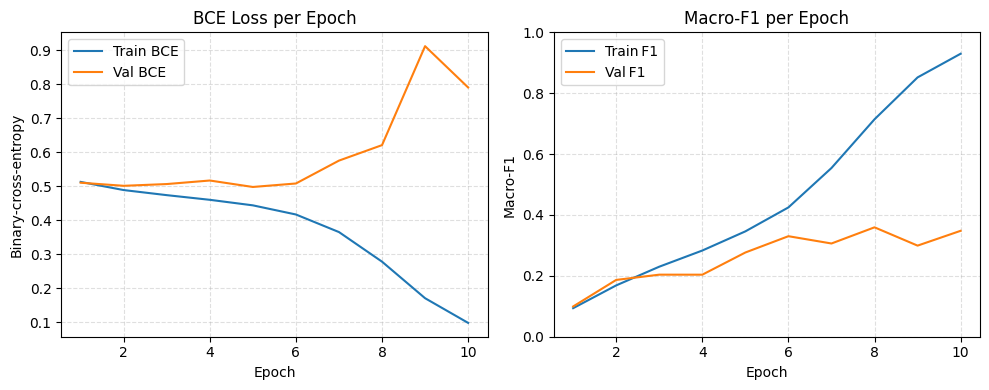

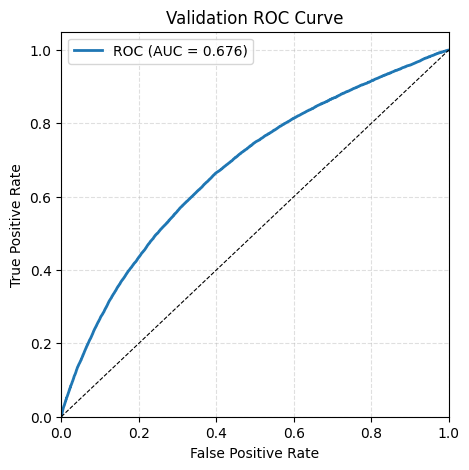

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train BCE')
plt.plot(epochs, val_losses,   label='Val BCE')
plt.xlabel('Epoch'); plt.ylabel('Binary-cross-entropy')
plt.title('BCE Loss per Epoch'); plt.legend(); plt.grid(True, ls='--', alpha=.4)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, label='Train F1')
plt.plot(epochs, val_f1s,   label='Val F1')
plt.xlabel('Epoch'); plt.ylabel('Macro-F1'); plt.ylim(0, 1)
plt.title('Macro-F1 per Epoch'); plt.legend(); plt.grid(True, ls='--', alpha=.4)

plt.tight_layout(); plt.show()

if COLLECT_ROC:
    import numpy as np, matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    logits   = torch.cat(_val_logits)
    targets  = torch.cat(_val_targets)
    probs    = torch.sigmoid(logits).numpy()
    y_true   = targets.numpy()

    fpr, tpr, _ = roc_curve(y_true.ravel(), probs.ravel())
    roc_auc     = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=.8)
    plt.xlim([0, 1]); plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Validation ROC Curve")
    plt.legend(); plt.grid(ls='--', alpha=.4); plt.show()



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ResNet18Scratch(num_classes=6)
model.load_state_dict(torch.load("resnet_model.pth", map_location=device))
model = model.to(device).eval()
criterion = nn.BCEWithLogitsLoss().to(device)
test_dataset = LabeledImageDataset(X_test, y_test, "split_dataset/test", transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate_model(
    model, test_loader, criterion, device)

In [ ]:
print("\n Final Test‑Set Evaluation")
print(f"   Loss  : {test_loss:.4f}")
print(f"   Acc   : {test_acc:.2f}%")
print(f"   Prec  : {test_prec:.2f}")
print(f"   Rec   : {test_rec:.2f}")
print(f"   F1    : {test_f1:.2f}")


 Final Test‑Set Evaluation
   Loss  : 0.5328
   Acc   : 32.00%
   Prec  : 0.38
   Rec   : 0.31
   F1    : 0.32


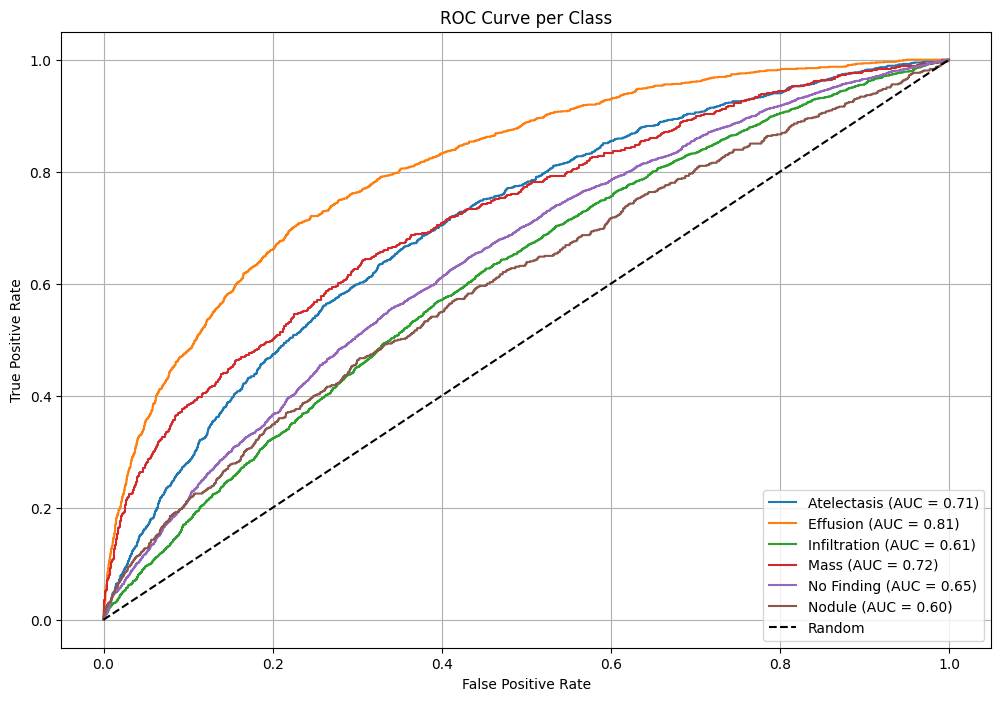

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

_val_logits, _val_targets = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _val_logits.append(logits.cpu())
        _val_targets.append(labels.cpu())

logits = torch.cat(_val_logits).numpy()
targets = torch.cat(_val_targets).numpy()

n_classes = targets.shape[1]
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(targets[:, i], logits[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{all_conditions[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


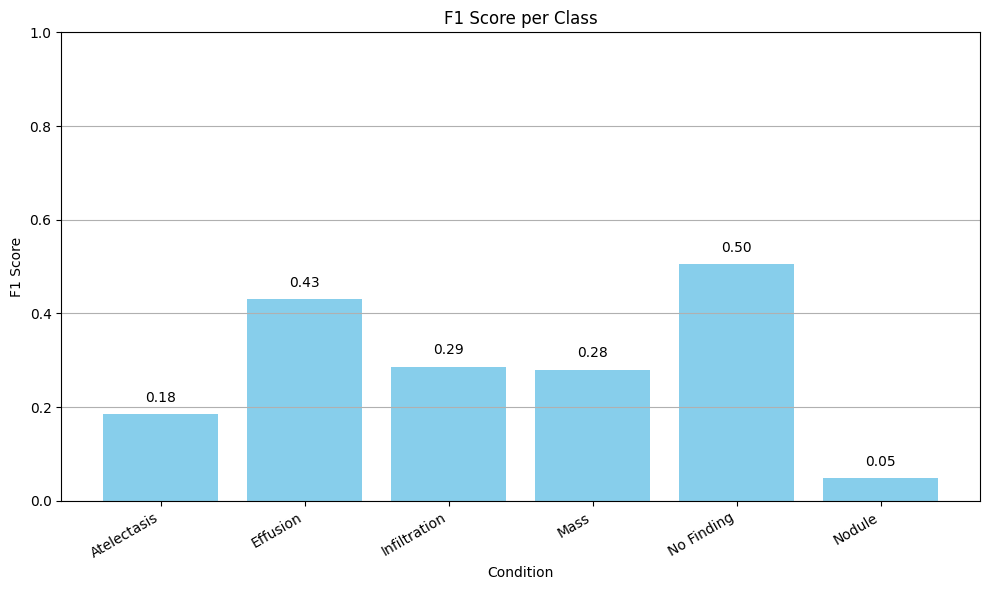

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

preds = (logits > 0.5).astype(int)
f1_per_class = f1_score(targets, preds, average=None, zero_division=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(all_conditions, f1_per_class, color='skyblue')
plt.ylabel("F1 Score")
plt.xlabel("Condition")
plt.ylim(0, 1)
plt.title("F1 Score per Class")
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()